In [1]:
from keras import applications
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation, Reshape, LeakyReLU
from keras.callbacks import CSVLogger
import tensorflow as tf
from scipy.ndimage import imread
import numpy as np
import random
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.backend.tensorflow_backend import set_session
from keras import optimizers
import h5py
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
import matplotlib
import h5py
import matplotlib.pyplot as plt
import math  

Using TensorFlow backend.


In [2]:

with h5py.File(''.join(['bitcoin2015to2017_close.h5']), 'r') as hf:
    datas = hf['inputs'].value
    labels = hf['outputs'].value
    input_times = hf['input_times'].value
    output_times = hf['output_times'].value
    original_inputs = hf['original_inputs'].value
    original_outputs = hf['original_outputs'].value
    original_datas = hf['original_datas'].value

/Users/noveshgarg/anaconda2/lib/python2.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [3]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [5]:
scaler=MinMaxScaler()

training_size = int(0.8* datas.shape[0])
training_datas = datas[:training_size,:,:]
training_labels = labels[:training_size,:,0]
validation_datas = datas[training_size:,:,:]
validation_labels = labels[training_size:,:,0]
validation_original_outputs = original_outputs[training_size:,:,:]
validation_original_inputs = original_inputs[training_size:,:,:]
validation_input_times = input_times[training_size:,:,:]
validation_output_times = output_times[training_size:,:,:]

In [6]:
ground_true = np.append(validation_original_inputs,validation_original_outputs, axis=1)
ground_true.shape

(294, 272, 1)

In [7]:
ground_true_times = np.append(validation_input_times,validation_output_times, axis=1)
ground_true_times.shape

(294, 272, 1)

In [8]:
step_size = datas.shape[1]
batch_size= 8
nb_features = datas.shape[2]
epochs = 1
output_size=16
units= 50
second_units=30

In [9]:
model = Sequential()
model.add(LSTM(units=units,activation='tanh', input_shape=(step_size,nb_features),return_sequences=False))
#model.add(LSTM(units=second_units,activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(output_size))
model.add(LeakyReLU())
model.load_weights('weights/bitcoin2015to2017_close_LSTM_1_tanh_leaky_-15-0.00024.hdf5')
model.compile(loss='mse', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [10]:
original_datas.shape

(399724, 1)

In [11]:
predicted = model.predict(validation_datas)
predicted_inverted = []

# In[7]:
# we only care about the 0 axis, close price data

scaler.fit(original_datas[:,0].reshape(-1,1))
predicted_inverted.append(scaler.inverse_transform(predicted))
print np.array(predicted_inverted).shape
#get only the close data
ground_true = ground_true[:,:,0].reshape(-1)
ground_true_times = ground_true_times.reshape(-1)
ground_true_times = pd.to_datetime(ground_true_times, unit='s')
# since we are appending in the first dimension
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)
print np.array(predicted_inverted).shape
validation_output_times = pd.to_datetime(validation_output_times.reshape(-1), unit='s')

(1, 294, 16)
(4704,)


In [12]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true
print(ground_true_df['value'])
ground_true_df.set_index('times').reset_index()
ground_true_df.shape

0        11539.999996
1        11550.354047
2        11506.915018
3        11502.000004
4        11539.791133
5        11525.874474
6        11545.000000
7        11495.000000
8        11496.076400
9        11520.000001
10       11517.000000
11       11520.000000
12       11517.980935
13       11516.011013
14       11500.000000
15       11507.699729
16       11527.504064
17       11526.363530
18       11540.990000
19       11550.000000
20       11525.347289
21       11542.000001
22       11537.464858
23       11487.407700
24       11465.475353
25       11465.475353
26       11470.126979
27       11454.145400
28       11465.686536
29       11489.999999
             ...     
79938     3450.402800
79939     3444.400000
79940     3436.000004
79941     3441.589700
79942     3437.969500
79943     3438.100000
79944     3435.210000
79945     3413.640400
79946     3407.238310
79947     3407.238312
79948     3402.504400
79949     3427.047610
79950     3425.011200
79951     3432.970000
79952     

(79968, 2)

In [13]:
prediction_df = pd.DataFrame()
prediction_df['times'] = validation_output_times
prediction_df['value'] = predicted_inverted
a=ground_true_df['value']-prediction_df['value']
b=a**2

b=a.sum()
b=107995030
print(b)
b=b/4704

b=math.sqrt(b)

print(b)
#print(a)
#print(prediction_df['value'])
prediction_df.shape

107995030
151.518975709


(4704, 2)

In [14]:
prediction_df.head()

,times,value
0,2018-03-06 09:50:00,10605.501953
1,2018-03-06 09:55:00,10498.056641
2,2018-03-06 10:00:00,10455.239258
3,2018-03-06 10:05:00,10370.767578
4,2018-03-06 10:10:00,10504.579102


In [15]:
prediction_df = prediction_df.loc[(prediction_df["times"].dt.year == 2018 )&(prediction_df["times"].dt.month > 8 ),: ]
ground_true_df = ground_true_df.loc[(ground_true_df["times"].dt.year == 2018 ),:]

/Users/noveshgarg/anaconda2/lib/python2.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


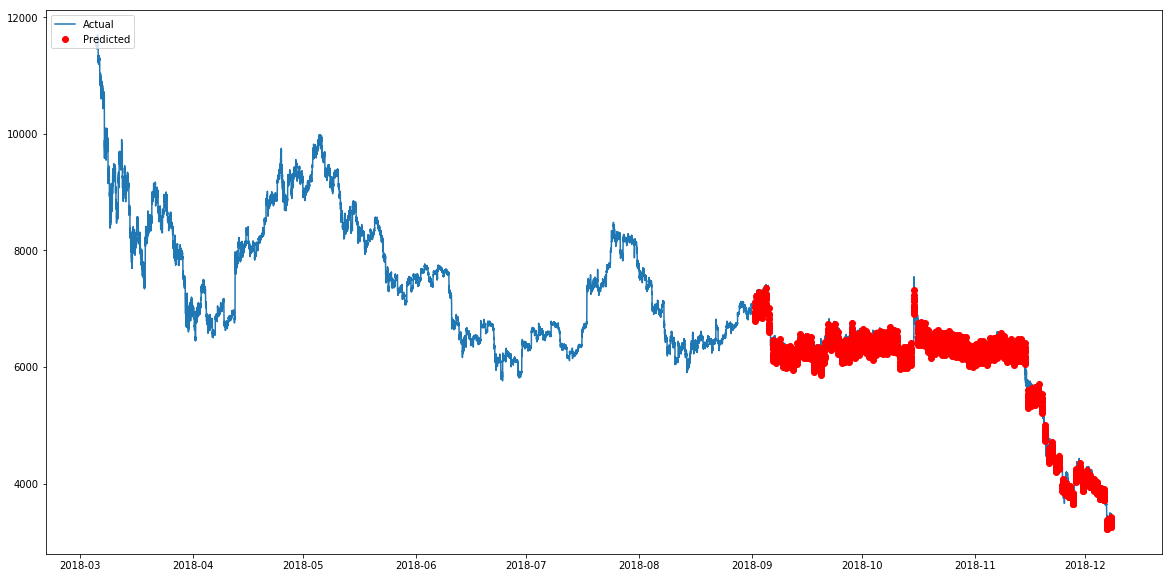

In [16]:
plt.figure(figsize=(20,10))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')
# plt.plot(prediction_df.times,prediction_df.value, label = 'Predicted')
plt.plot(prediction_df.times,prediction_df.value,'ro', label='Predicted')
plt.legend(loc='upper left')
plt.savefig('result/bitcoin2015to2017_close_LSTM_1_tanh_leaky_result.png')
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
mean_squared_error(validation_original_outputs[:,:,0].reshape(-1),predicted_inverted)

95882.7459674845